<a href="https://colab.research.google.com/github/shcho11/03.IBM_AIEngineering_Keras/blob/main/202302_TF_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practices at IBM AI Engineering "Building Deep Learning Models with TensorFlow" Course (2023.02)
- Deep Convolutional Neural Network using MNIST Dataset 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.51.1
    Uninstalling grpcio-1.51.1:
      Successfully uninstalled grpcio-1.51.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.24.3 which is incompatible.
google-cloud-bigquery 3.4.2 requires grpcio<2.0dev,>=1.47.0, but you have grpcio 1.24.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if not tf.__version__ == '2.2.0':
    printmd('<<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.2.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>>')

# 1st part: classify MNIST using a simple model.

### Import the MNIST dataset using TensorFlow built-in feature

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
# The features data are between 0 and 255, and we will normalize this to improve optimization performance.

x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
# the first few label values:

print(y_train[0:5])

[5 0 4 1 9]


In [8]:
"""
the current label scheme simply identifies the category to which each data point belongs 
(each handwritten digit is assigned a category equal to the number value). 
We need to convert this into a one-hot encoded vector.

for example, 
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
"""

print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [10]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

# Validation data is not used in this example.

number of training examples: 60000
number of test examples: 10000


In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

### Converting a 2D Image into a 1D Vector

In [12]:
#  To make the input useful to us, we need these to be arranged in a 1D vector (Flatten)
# showing an example of the Flatten class and operation

from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


### Assigning bias and weights to null tensors

In [13]:
"""
Since these values will be adjusted during the optimization process, we define them using  `tf.Variable`.
NOTE:  `tf.Variable` creates adjustable variables that are in the global namespace, 
so any function that references these variables need not pass the varibles.
But they are globals, so exercise caution when naming!
"""

# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

### Adding Weights and Biases to input

In [15]:
# The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.

def forward(x):
    return tf.matmul(x,W) + b

### Softmax Regression

In [16]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [18]:
# Now we can define our output layer

def activate(x):
    return tf.nn.softmax(forward(x))

In [19]:
# Let's create a `model` function for convenience.

def model(x):
    x = flatten(x)
    return activate(x)

### Cost Function
- It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network. Here we use the cross entropy function, which is a popular cost function used for categorical models. 

In [20]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

# addition of 1e-10 to prevent errors in zero calculations
# current loss function for unoptimized model

cross_entropy(y_train, model(x_train)).numpy()

138155.0

### Type of optimization: Gradient Descent
- This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [22]:
"""
Now we define the training step. 
This step uses GradientTape to automatically compute deriviatives of the functions 
that we have manually created and applies them using the SGD optimizer.
"""

def train_step(x, y ):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

### Training Batches
- Due to Batch Gradient's Expensive Computation problem, Neural Networks usually use minibatch to train.
- We have already divided our full dataset into batches of 50 each using the Datasets API. Now we can iterate through each of those batches to compute a gradient. Once we iterate through all of the batches in the dataset, we complete an epoch, or a full traversal of the dataset.

In [23]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 


epoch  0 batch 500 loss: 177.26141
epoch  0 batch 1000 loss: 174.39491
end of epoch  0 loss 223471.0 accuracy 0.8147
epoch  1 batch 500 loss: 153.2364
epoch  1 batch 1000 loss: 178.1075
end of epoch  1 loss 216641.61 accuracy 0.824
epoch  2 batch 500 loss: 209.28334
epoch  2 batch 1000 loss: 172.85431
end of epoch  2 loss 207265.33 accuracy 0.83315
epoch  3 batch 500 loss: 203.7942
epoch  3 batch 1000 loss: 152.35666
end of epoch  3 loss 210062.88 accuracy 0.8303
epoch  4 batch 500 loss: 189.21526
epoch  4 batch 1000 loss: 163.97006
end of epoch  4 loss 211364.31 accuracy 0.82985
epoch  5 batch 500 loss: 215.90894
epoch  5 batch 1000 loss: 175.0403
end of epoch  5 loss 202569.7 accuracy 0.83845
epoch  6 batch 500 loss: 200.97389
epoch  6 batch 1000 loss: 167.53844
end of epoch  6 loss 207683.56 accuracy 0.83435
epoch  7 batch 500 loss: 200.98653
epoch  7 batch 1000 loss: 185.46494
end of epoch  7 loss 200680.2 accuracy 0.8413333
epoch  8 batch 500 loss: 213.95403
epoch  8 batch 1000 lo

### Tests and Plots
- It is common to run intermittent diagnostics (such as accuracy and loss over entire dataset) during training.  Here we compute a summary statistic on the test dataset as well.  Fitness metrics for the training data should closely match those of the test data.  If the test metrics are distinctly less favorable, this can be a sign of overfitting.

In [24]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84305
test accuracy 0.8355


Text(0, 0.5, 'loss')

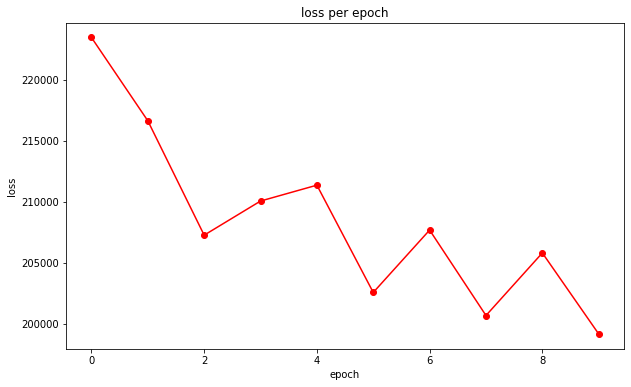

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

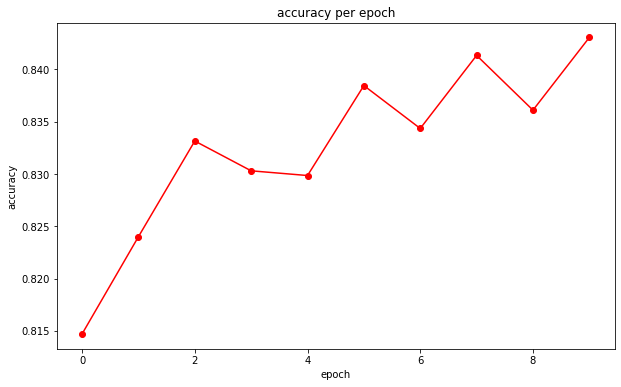

In [26]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

# 2nd part: Deep Learning applied on MNIST

In [27]:
# general (Initial) parameters for the model

width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [28]:
# Converting images of the data set to tensors

x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [29]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

## Convolutional Layer 1

- Defining kernel weight and bias
- We define a kernel here. The Size of the filter/kernel is 5x5; Input channels is 1 (grayscale); and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]

In [30]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [31]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

### Apply the ReLU activation Function
- In this step, we just go through all outputs convolution layer, convolve1, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.

In [32]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

### Apply the max pooling
- max pooling is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region.
- Lets use tf.nn.max_pool function to perform max pooling. Kernel size: 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)
- Strides: dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

In [33]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

## Convolution Layer 2
We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5 (25 pixels) 
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) 
- 64 output feature maps 

In [34]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [35]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [36]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

In [37]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

## Fully Connected Layer
- You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

- So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]

In [38]:
# Flattening the second layer 

def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

In [39]:
# Weights and Biases between layer 2 and 3
# Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer

W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [40]:
# Matrix Multiplication (applying weights and biases)

def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [41]:
# Apply the ReLu Function 

def h_fc1(x): return tf.nn.relu(fcl(x))

### (Optional) Dropout Layer, Optional phase for reducing overfitting
- his can be very useful for very large neural networks to prevent overfitting.

In [42]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

In [43]:
"""
In last layer, CNN takes the high-level filtered images and translate them into votes using softmax. 
Input channels: 1024 (neurons from the 3rd Layer); 10 output features
"""
# Weights and biases 

W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

In [44]:
# Matrix Multiplication (applying weights and biases)

def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [45]:
# Apply the Softmax activation Function

def y_CNN(x): return tf.nn.softmax(fc(x))

## Summary : the Structure of Deep Convolutional Neural Network 

0) Input - MNIST dataset <br>
1) Convolutional and Max-Pooling <br>
2) Convolutional and Max-Pooling <br>
3) Fully Connected Layer <br>
4) Processing - Dropout <br>
5) Readout layer - Fully Connected <br>
6) Outputs - Classified digits <br>

In [47]:
# The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified.

import numpy as np
layer4_test =[[0.9, 0.1, 0.1],[0.9, 0.1, 0.1]]
y_test=[[1.0, 0.0, 0.0],[1.0, 0.0, 0.0]]
np.mean( -np.sum(y_test * np.log(layer4_test),1))

0.10536051565782628

In [48]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

### Define the optimizer
- It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent or Adagrad.


In [49]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [50]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()


In [51]:
# Define prediction

correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

In [52]:
# Define Accuracy 

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

In [53]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 107.64598 accuracy 0.38
epoch  0 batch 100 loss: 61.08529 accuracy 0.64
epoch  0 batch 150 loss: 41.37803 accuracy 0.8
epoch  0 batch 200 loss: 22.202147 accuracy 0.88
epoch  0 batch 250 loss: 26.163513 accuracy 0.8
epoch  0 batch 300 loss: 21.30651 accuracy 0.82
epoch  0 batch 350 loss: 31.073671 accuracy 0.84
epoch  0 batch 400 loss: 16.204866 accuracy 0.9
epoch  0 batch 450 loss: 22.210464 accuracy 0.88
epoch  0 batch 500 loss: 12.423323 accuracy 0.9
epoch  0 batch 550 loss: 16.173101 accuracy 0.88
epoch  0 batch 600 loss: 23.703148 accuracy 0.82
epoch  0 batch 650 loss: 25.30949 accuracy 0.88
epoch  0 batch 700 loss: 12.354191 accuracy 0.96
epoch  0 batch 750 loss: 31.765522 accuracy 0.86
epoch  0 batch 800 loss: 8.04476 accuracy 0.98
epoch  0 batch 850 loss: 12.937878 accuracy 0.94
epoch  0 batch 900 loss: 11.828795 accuracy 0.92
epoch  0 batch 950 loss: 13.738506 accuracy 0.92
epoch  0 batch 1000 loss: 15.022094 accuracy 0.88
epoch  0 batch 1050 loss: 2.19

95% accuracy after only 1 epoch!

## Evaluate the Model

In [54]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))            

batch 100 accuracy 0.96
batch 200 accuracy 1.0
batch 300 accuracy 0.92
batch 400 accuracy 0.96
batch 500 accuracy 0.92
batch 600 accuracy 0.88
batch 700 accuracy 0.94
batch 800 accuracy 0.96
batch 900 accuracy 0.9
batch 1000 accuracy 0.96
batch 1100 accuracy 0.94
batch 1200 accuracy 0.96
accuracy of entire set 0.9398


In [55]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

--2023-02-09 12:45:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2023-02-09 12:45:45 (878 MB/s) - ‘utils1.py’ saved [5097/5097]



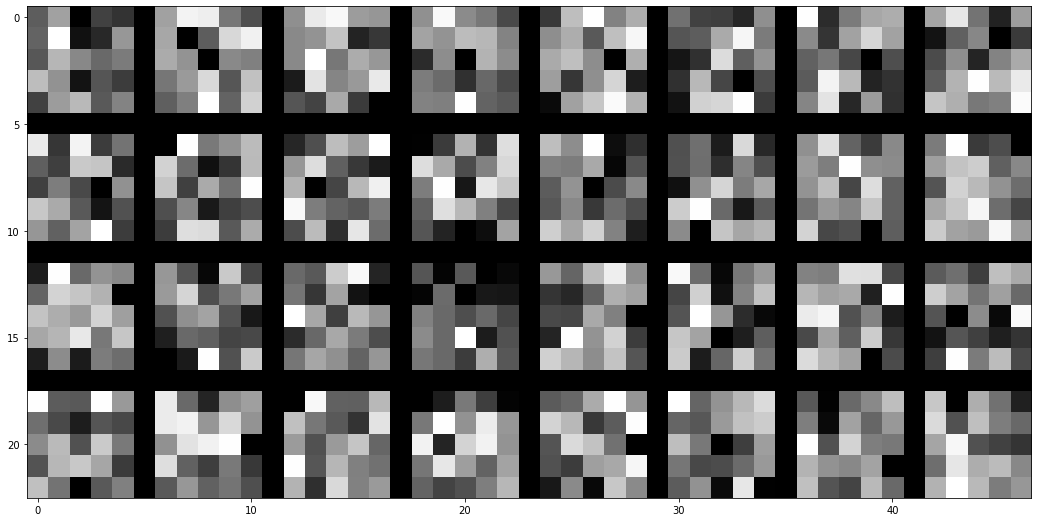

In [56]:
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

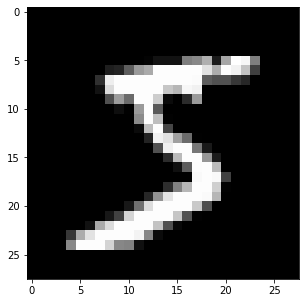

In [57]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

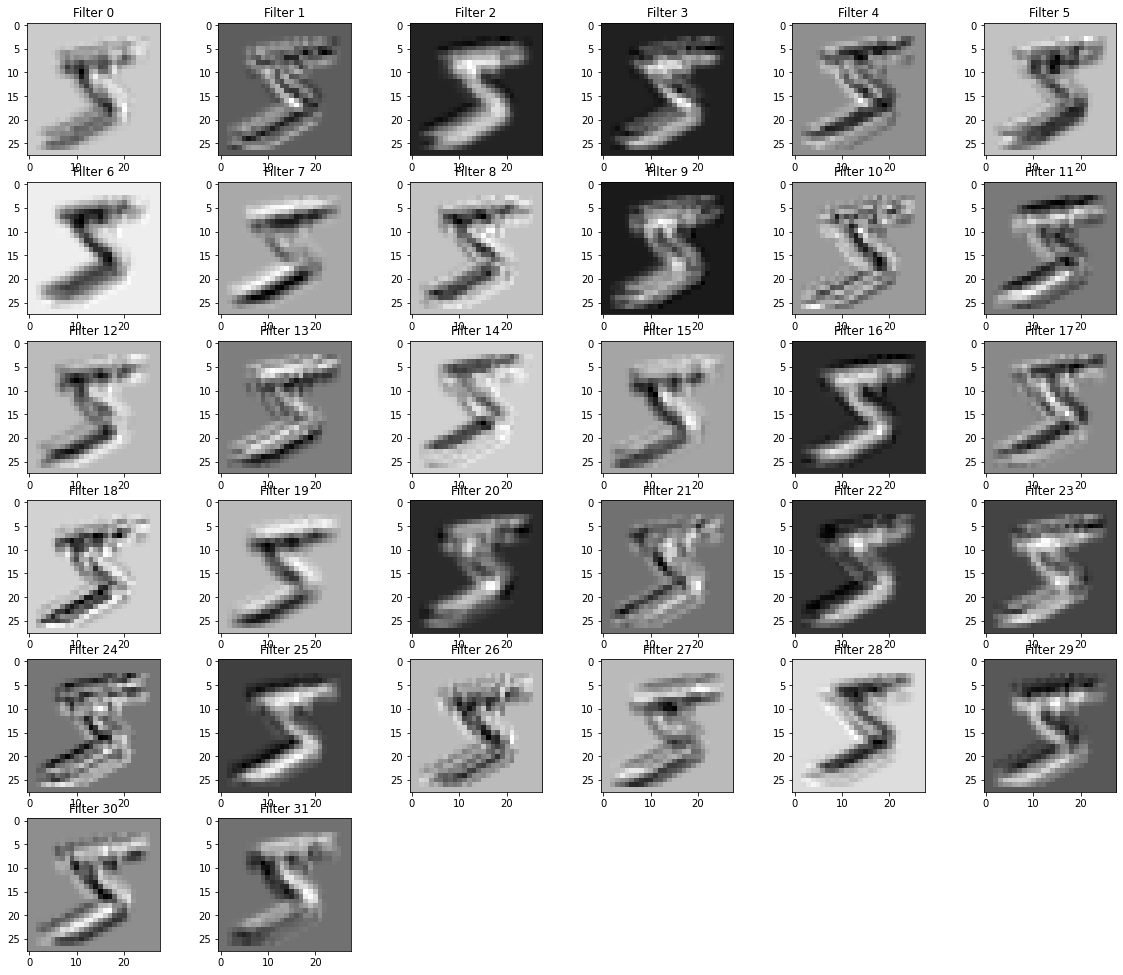

In [58]:
#ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

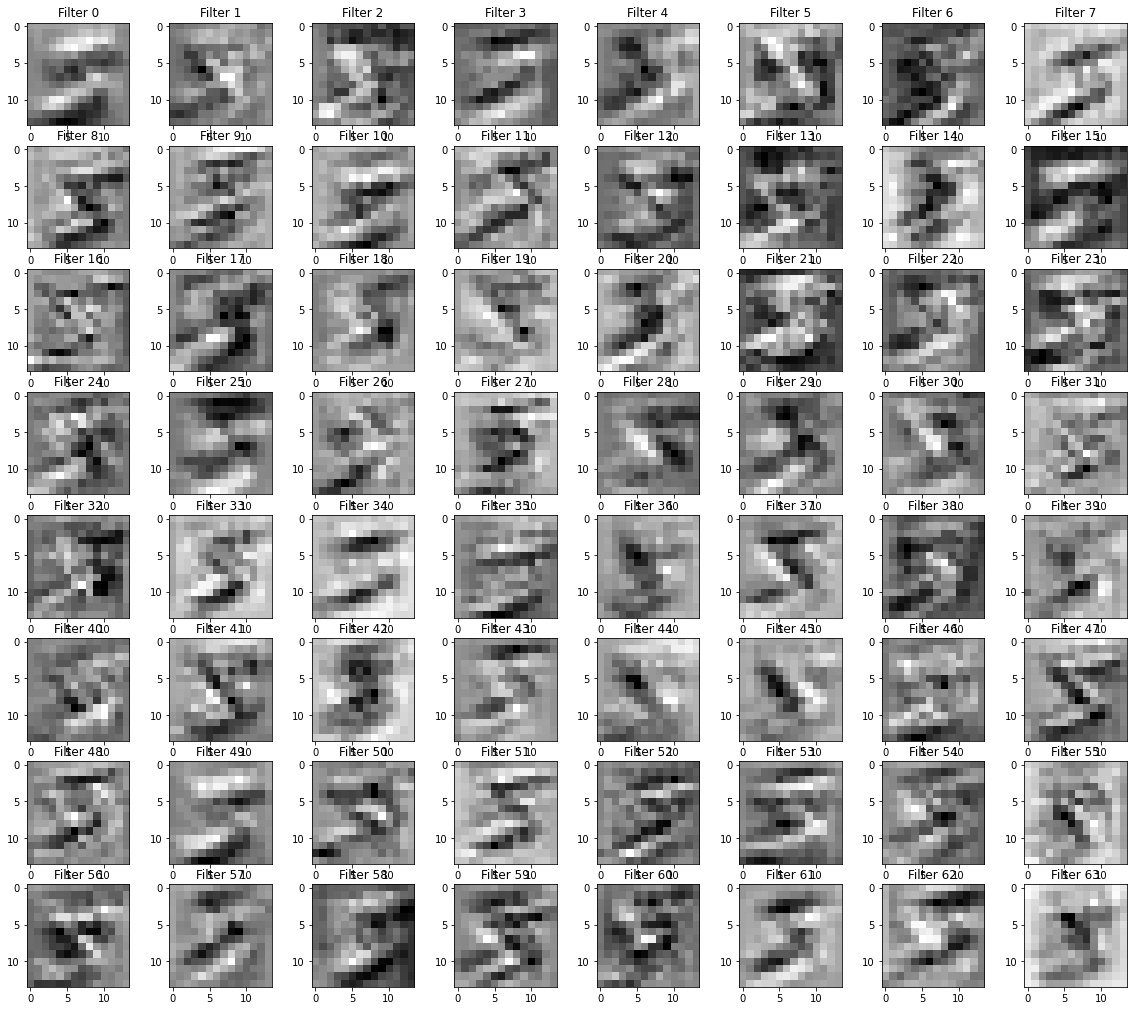

In [59]:
# Second Convolutional Layer 

#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")